In [211]:
import re
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import nltk
from spellchecker import SpellChecker
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from yellowbrick.text.freqdist import FreqDistVisualizer 

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [212]:
#!pip install pyspellchecker

In [213]:
# dataset is taken from Kaggle
df_tweet = pd.read_csv('./dataset/train.csv')

# Note: this df does not have the target column
df_test = pd.read_csv('./dataset/test.csv')

In [214]:
print('There are {} rows and {} columns in the training dataset'.
      format(df_tweet.shape[0],df_tweet.shape[1]))

print('There are {} rows and {} columns in the testing dataset'.
      format(df_test.shape[0],df_test.shape[1]))

There are 7613 rows and 5 columns in the training dataset
There are 3263 rows and 4 columns in the testing dataset


In [215]:
# train data
df_tweet.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [216]:
# test data . Note: it does not have target column and just can be used for testing
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [217]:
print('missing values of the keyword column: {}/{} ({}%)'.
      format(df_tweet.keyword.isna().sum(),len(df_tweet),
             round((df_tweet.keyword.isna().sum() / len(df_tweet)) * 100,2)))

print('missing values of the location column: {}/{} ({}%)'.
      format(df_tweet.location.isna().sum(), len(df_tweet),
             round((df_tweet.location.isna().sum() / len(df_tweet)) * 100,2)))

missing values of the keyword column: 61/7613 (0.8%)
missing values of the location column: 2533/7613 (33.27%)


In [218]:
print('class 0: {} cases'.format(df_tweet.target.value_counts()[0]))
print('class 1: {} cases'.format(df_tweet.target.value_counts()[1]))

class 0: 4342 cases
class 1: 3271 cases


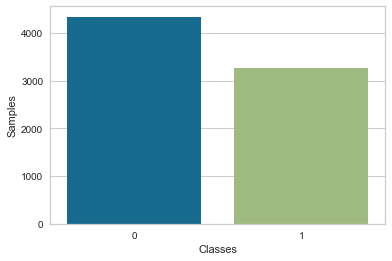

In [219]:
# the number of classes are almost balanced. So, we do not need to balance them.
# However, there are more tweets with class 0 (No disaster) than class 1 (disaster tweets)
target_counts = df_tweet.target.value_counts()
sns.barplot(target_counts.index,target_counts)
plt.gca().set_ylabel('Samples')
plt.gca().set_xlabel('Classes')
plt.show();

### Number of characters in tweets

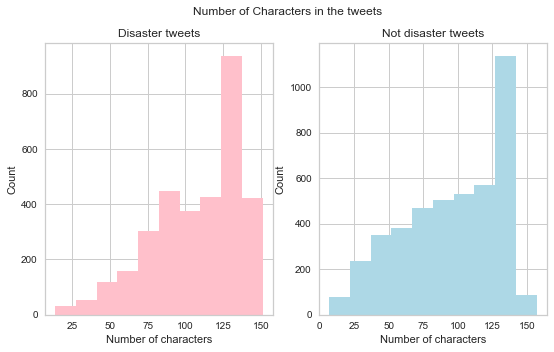

In [220]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,5))

tweet_disaster_len=df_tweet[df_tweet.target == 1]['text'].str.len()
ax1.hist(tweet_disaster_len,color='pink')
ax1.set_title('Disaster tweets')
ax1.set_xlabel('Number of characters')
ax1.set_ylabel('Count')

tweet_not_disaster_len=df_tweet[df_tweet.target == 0]['text'].str.len()
ax2.hist(tweet_not_disaster_len,color='lightblue')
ax2.set_title('Not disaster tweets')
ax2.set_xlabel('Number of characters')
ax2.set_ylabel('Count')

fig.suptitle('Number of Characters in the tweets')
plt.show();

### Number of words in a tweet

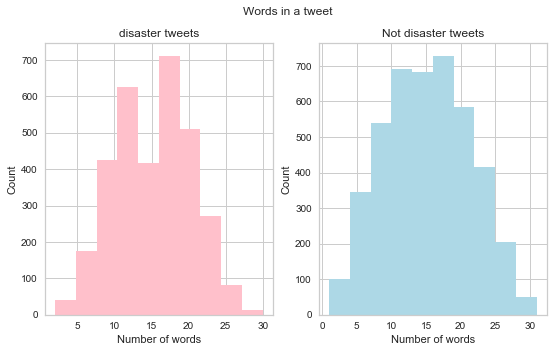

In [221]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(9,5))
tweet_disaster_len=df_tweet[df_tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_disaster_len,color='pink')
ax1.set_title('disaster tweets')
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Count')

tweet_not_disaster_len=df_tweet[df_tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_not_disaster_len,color='lightblue')
ax2.set_title('Not disaster tweets')
ax2.set_xlabel('Number of words')
ax2.set_ylabel('Count')

fig.suptitle('Words in a tweet')
plt.show();

we are going to drop the columns which have missing values as well as ID. 
ID does not add any value to the model that we are about to create.

In [222]:
df_tweet.drop(['id','location', 'keyword'], axis=1, inplace=True)
df_test.drop(['id','location', 'keyword'], axis=1, inplace=True)

In [223]:
df_tweet.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### Cleaning data
-Remove URLs <br>
-Remove HTML tags <br>
-Remove special characters <br>
-etc

In [224]:
# combine train and test dataframes
df_combined = pd.concat([df_tweet, df_test], sort=False, ignore_index=True).reindex()
print(df_combined.shape)

(10876, 2)


In [225]:
def remove_URLs(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html_tags(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punctuations(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def correct_spellings(text):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


def clean_data(df):
    
    documents = list()
    ps = PorterStemmer()
    #wnl = WordNetLemmatizer()

    for i in range(0, len(df)):

        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(df.loc[i,'text']))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to lowercase
        document = document.lower()

        # lemmatization and stemmer
        # In lemmatization, we can convert the word into the root form of the word. 
        # for exampel, "houses" is converted into "house".
        document = document.split()
        document = [ps.stem(word) for word in document]
        document = ' '.join(document)

        documents.append(document)
    return documents

In [226]:
df_combined['text'] = df_combined['text'].apply(lambda x : remove_URLs(x))
df_combined['text'] = df_combined['text'].apply(lambda x : remove_html_tags(x))
df_combined['text'] = df_combined['text'].apply(lambda x : remove_punctuations(x))
# it takes long time to execute
#df_tweet['text'] = df_tweet['text'].apply(lambda x : correct_spellings(x))
documents = list(clean_data(df_combined))

In [227]:
len(documents)

10876

In [228]:
df_combined[100:110]

,text,target
100,NorwayMFA Bahrain police had previously died in a road accident they were not killed by explosion,1.0
101,I still have not heard Church Leaders of Kenya coming forward to comment on the accident issue and disciplinary measuresArrestPastorNganga,0.0
102,afterShockDeLo scuf ps live and the game cya,0.0
103,The man who can drive himself further once the effort gets painful is the man who will win \nRoger Bannister,0.0
104,320 IR ICEMOON AFTERSHOCK djicemoon Dubstep TrapMusic DnB EDM Dance IcesÛ,0.0
105,There is no victory at bargain basement prices Dwight David Eisenhower,0.0
106,320 IR ICEMOON AFTERSHOCK djicemoon Dubstep TrapMusic DnB EDM Dance IcesÛ,0.0
107,Nobody remembers who came in second Charles Schulz,0.0
108,afterShockDeLo im speaking from someone that is using a scuf on xb1 most of them people will end up getting on for ps also,0.0
109,The harder the conflict the more glorious the triumph Thomas Paine,0.0


In [229]:
# print 10 rows
documents[100:110]

['norwaymfa bahrain polic had previous die in road accid they were not kill by explos',
 'i still have not heard church leader of kenya come forward to comment on the accid issu and disciplinari measuresarrestpastornganga',
 'aftershockdelo scuf ps live and the game cya',
 'the man who can drive himself further onc the effort get pain is the man who will win roger bannist',
 '320 ir icemoon aftershock djicemoon dubstep trapmus dnb edm danc ice û',
 'there is no victori at bargain basement price dwight david eisenhow',
 '320 ir icemoon aftershock djicemoon dubstep trapmus dnb edm danc ice û',
 'nobodi rememb who came in second charl schulz',
 'aftershockdelo im speak from someon that is use scuf on xb1 most of them peopl will end up get on for ps also',
 'the harder the conflict the more gloriou the triumph thoma pain']

## Converting Text to Numbers

Machines cannot understand the raw text. Machines can only understand numbers. 
Statistical techniques including machine learning can only deal with numbers. 
Therefore, we need to convert our text into numbers.

<ul>   
   <li><b>max_features:</b> Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus</li>
    <li><b>max_df:</b> When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold.</li>
    </ul>

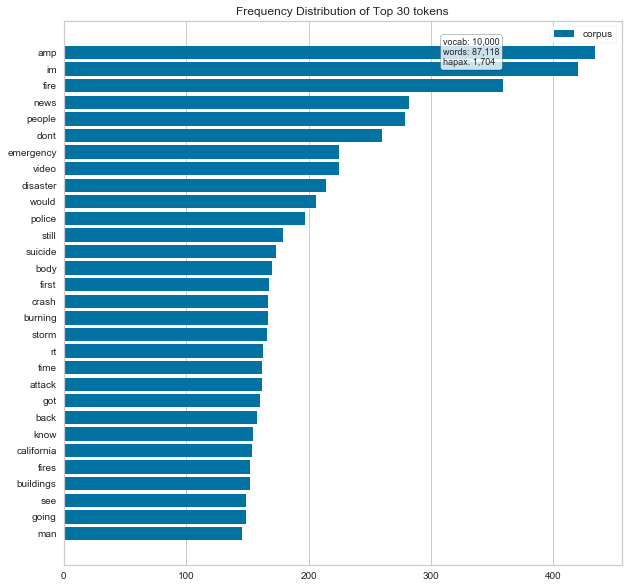

In [230]:
# Find the document term frequency matrix
stopwords = nltk.corpus.stopwords.words('english')

# add some more stop words
newStopWords = ['http','https', 'co', 'via', 'us','like','one','get','new','û']
stopwords.extend(newStopWords)

vectorizer = CountVectorizer(max_features=10000,
                             analyzer='word',
                             max_df=.6,
                             stop_words=stopwords)

X = vectorizer.fit_transform(df_combined['text'])
#X = vectorizer.fit_transform(documents).toarray()

# Get all features (tokens)
features = vectorizer.get_feature_names()

# we can use yellowbrick package for visualization of top 30 tokens
fig, ax = plt.subplots(figsize=(10, 10))
visualizer = FreqDistVisualizer(features=features, n=30, orient='h')
visualizer.fit(X)
visualizer.poof()

In [231]:
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()

X = tfidfconverter.fit_transform(X).toarray()
y = df_tweet['target']

#split data into train and test set
train_set_X = X[:df_tweet.shape[0]]
test_set_X = X[df_tweet.shape[0]:]

In [232]:
X_train, X_test, y_train, y_test = train_test_split(train_set_X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

### Creating the model

In [233]:
rfc = RandomForestClassifier(n_estimators=800, 
                             random_state=42, 
                             max_features='auto')

rfc.fit(X_train, y_train)

# predict for testing data
y_pred_test = rfc.predict(X_test)

# predict for training data
y_pred_train = rfc.predict(X_train)

In [234]:
# test
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

0.7850262697022767
[[1168  170]
 [ 321  625]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1338
           1       0.79      0.66      0.72       946

   micro avg       0.79      0.79      0.79      2284
   macro avg       0.79      0.77      0.77      2284
weighted avg       0.79      0.79      0.78      2284



In [235]:
# train
print(accuracy_score(y_train, y_pred_train))
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))

0.9866766747982736
[[2987   17]
 [  54 2271]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3004
           1       0.99      0.98      0.98      2325

   micro avg       0.99      0.99      0.99      5329
   macro avg       0.99      0.99      0.99      5329
weighted avg       0.99      0.99      0.99      5329



### Save the Model

In [236]:
#The wb indicates that the file is opened for writing in binary mode
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(rfc,picklefile)

### Load the Model

In [237]:
#The rb indicates that the file is opened for reading in binary mode
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

### Make prediction based on the Loaded model

In [238]:
y_pred_test_2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred_test_2))
print(classification_report(y_test, y_pred_test_2))
print(accuracy_score(y_test, y_pred_test_2)) 

[[1168  170]
 [ 321  625]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1338
           1       0.79      0.66      0.72       946

   micro avg       0.79      0.79      0.79      2284
   macro avg       0.79      0.77      0.77      2284
weighted avg       0.79      0.79      0.78      2284

0.7850262697022767


In [240]:
sample_sub = pd.read_csv('dataset/sample.csv')

In [242]:
y_pred_test_data = model.predict(test_set_X)
y_pred_test_data = np.round(y_pred_test_data).astype(int).reshape(3263)

sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'text':df_test['text'].values.tolist(),'target':y_pred_test_data})
sub.to_csv('output.csv',index=False)